## Causal Inference: Instrumental Variable 
From https://github.com/amit-sharma/causal-inference-tutorial/blob/master/python/advanced_example_with_refutation.ipynb
and 
https://microsoft.github.io/dowhy/dowhy_simple_example.html

In [1]:
import numpy as np
import pandas as pd
import dowhy
from collections import namedtuple
from dowhy import datasets
from dowhy import CausalModel

Let us first load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [2]:
beta = 10
data = datasets.linear_dataset(beta,
        num_common_causes=5,
        num_instruments=2,
        num_samples=10000, 
        treatment_is_binary=True)
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.374411,-0.896899,2.870235,0.018950,0.504303,1.041548,True,22.347365
1,1.0,0.915665,-1.053148,0.116219,2.243496,-0.279278,1.727769,True,10.953278
2,1.0,0.282427,-1.321959,2.492538,-1.920368,-0.734497,2.355544,True,14.022011
3,1.0,0.337368,-1.453261,-0.624546,0.988766,-0.979020,2.215129,True,2.720615
4,1.0,0.092489,0.575437,-0.204101,0.523438,1.273053,2.936560,True,23.044417
5,0.0,0.852156,-0.589315,-0.575982,0.243573,-1.763625,0.814580,True,-0.343432
6,0.0,0.683598,-0.824636,1.044971,1.088262,-0.302412,0.611700,True,12.154394
7,1.0,0.423321,-0.458611,1.668900,0.103333,0.982210,1.547685,True,22.214060
8,1.0,0.761364,-1.778439,0.126064,1.709403,1.008378,1.073968,True,11.489658
9,1.0,0.709077,-0.874379,-3.180800,0.856107,0.353690,1.830075,True,-0.858326


## Step 1, Model: Input causal graph

In [3]:
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


In [4]:
model.view_model()

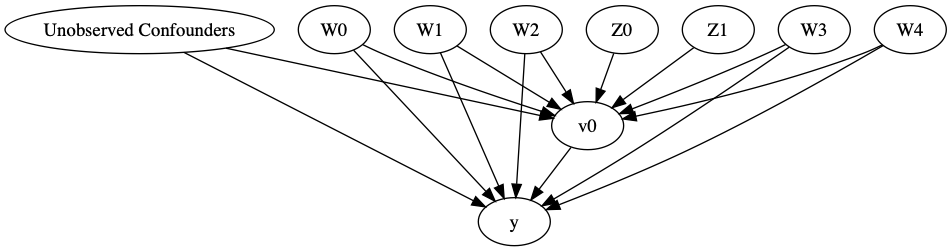

In [5]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

## Step 2: Idenfitifaction

In [6]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W2', 'W3', 'Unobserved Confounders', 'W0', 'W1', 'W4']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W0,W1,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W0,W1,W4,U) = P(y|v0,W2,W3,W0,W1,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)



## Step 3a: Estimation using IV 

In [7]:
def instrumental_variables_estimator(df, treatment_name="v0"):
        instrument = df["Z0"]
        num_unique_values = len(np.unique(instrument))
        instrument_is_binary= (num_unique_values <=2)
        if instrument_is_binary:
            # Obtain estimate by Wald Estimator
            y1_z =np.mean(df["y"][instrument==1])
            y0_z = np.mean(df["y"][instrument==0])
            x1_z = np.mean(df[treatment_name][instrument==1])
            x0_z = np.mean(df[treatment_name][instrument==0])
            num = y1_z - y0_z
            deno = x1_z - x0_z
            iv_est = num/deno
        else:
            # Obtain estimate by Pearl (1995) ratio estimator.
            # y = x+ u; multiply both sides by z and take expectation.
            num_yz = np.dot(df["y"], instrument)
            deno_xz = np.dot(df[treatment_name], instrument)
            iv_est = num_yz/deno_xz

        CausalEstimate = namedtuple('CausalEstimate', ['value'])
        estimate = CausalEstimate(value= iv_est)
        return estimate
    
causal_estimate = instrumental_variables_estimator(df)
print("Causal Estimate is " + str(causal_estimate.value))
print("Ground truth is " + str(beta))

Causal Estimate is 9.5109369460672
Ground truth is 10


## Step 3b: Estimation using backdoor & propensity score stratification

In [8]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W2+W3+W0+W1+W4


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W0,W1,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W0,W1,W4,U) = P(y|v0,W2,W3,W0,W1,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W2+W3+W0+W1+W4
## Estimate
Value: 10.055667244811882

Causal Estimate is 10.055667244811882


/anaconda3/envs/py37/lib/python3.7/site-packages/scikit_learn-0.21.2-py3.7-macosx-10.9-x86_64.egg/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/py37/lib/python3.7/site-packages/scikit_learn-0.21.2-py3.7-macosx-10.9-x86_64.egg/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Step 4: Refuting the estimate (Sensitivity Analysis) 

In [9]:
def refute_estimate_subset(df, causal_estimate, subset_fraction=0.8):
        new_data = df.sample(frac=subset_fraction)
        new_effect = instrumental_variables_estimator(new_data)
        refute = new_effect.value
        return(refute)

res_subset = refute_estimate_subset(df, causal_estimate)
print("Causal estimate was: {0}".format(causal_estimate.value))
print("New refuted estimate is: {0}".format(res_subset))

Causal estimate was: 10.055667244811882
New refuted estimate is: 8.930962705990833
